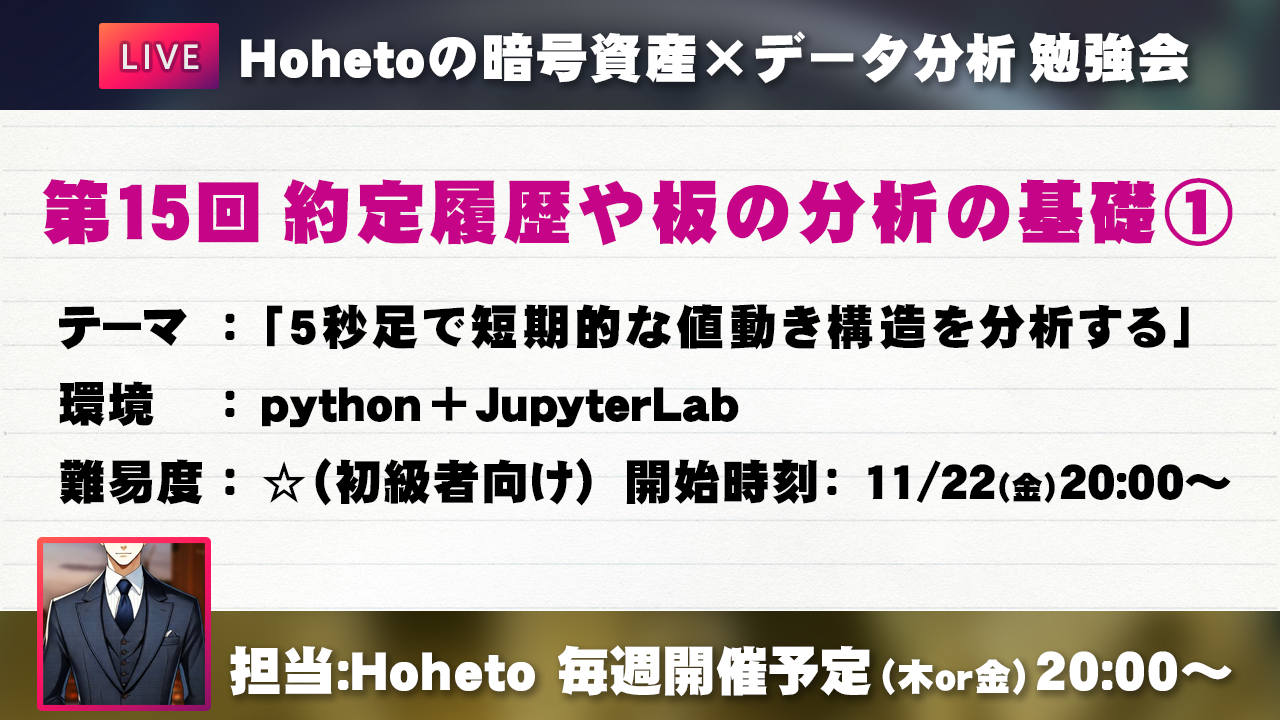

In [1]:
from IPython.display import Image

Image('./images/15_00.png')

# Hoheto勉強会 第15回 約定履歴や板の分析の基礎①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- 高頻度取引や執行分析に利用する約定履歴や板の分析を行います。
- 今回は秒足の作成方法について解説し、簡単な分析を行います。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆1つ。

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

- ローソク足プロット用

In [5]:
def plot_ohlc(df, sec=300, title=''):
    # secには、描画しようとしている足の秒数を指定.
    # 1分足 -> 60
    # 1時間足 -> 60 * 60 など.
    ax = plt.gca()
    ax.set_axisbelow(True)
    ax.grid(color='#eeeeee')
    ax.set_title(title)
    # ローソク足の幅を設定
    # matplotlib上でwidth=1->1日となるのでローソク足の時間軸に応じて幅を設定
    w = sec / (24 * 60 * 60)
    # ローソク足
    # 陽線と陰線で色を変えるため、それぞれのindexを取得
    idx1 = df.index[df['close'] > df['open']]
    idx0 = df.index[df['close'] < df['open']]
    idx2 = df.index[df['close'] == df['open']]
    # 実体
    df['body'] = np.abs(df['close'] - df['open'])
    ax.bar(idx1, df.loc[idx1, 'body'], width=w * (1 - 0.2), bottom=df.loc[idx1, 'open'], linewidth=1, color='#4caf50', zorder=2)
    ax.bar(idx0, df.loc[idx0, 'body'], width=w * (1 - 0.2), bottom=df.loc[idx0, 'close'], linewidth=1, color='#f23645', zorder=2)
    ax.bar(idx2, df.loc[idx2, 'body'], width=w * (1 - 0.2), bottom=df.loc[idx2, 'close'], linewidth=1, color='#666666', zorder=2)
    # ヒゲ
    # ax.vlines(df.index, df['low_perp'], df['high_perp'], linewidth=0.5, color='#666666', zorder=1)
    ax.vlines(idx1, df.loc[idx1, 'low'], df.loc[idx1, 'high'], linewidth=0.5, color='#4caf50', zorder=1)
    ax.vlines(idx0, df.loc[idx0, 'low'], df.loc[idx0, 'high'], linewidth=0.5, color='#f23645', zorder=1)
    ax.vlines(idx2, df.loc[idx2, 'low'], df.loc[idx2, 'high'], linewidth=0.5, color='#666666', zorder=1)
    ax.set_ylabel("PRICE")


- 相関プロット用

In [6]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

# 1分足未満の分析とは

## 秒足とは

- 1分足、1時間足、日足と同様、一定の秒ごとにサンプリングされた代表値。
- 1秒足、5秒足、15秒足、30秒足などを利用可能。

- どうやって作成する？
  - 取引所APIで公開されている、「約定履歴」を利用して自炊する。
  - 今回はこの自炊方法を解説します。

- bybitのBTCUSDT.Pの5秒足。
- チャートサイト（TradingViewなど）の有料プランだと表示可能な場合がある。

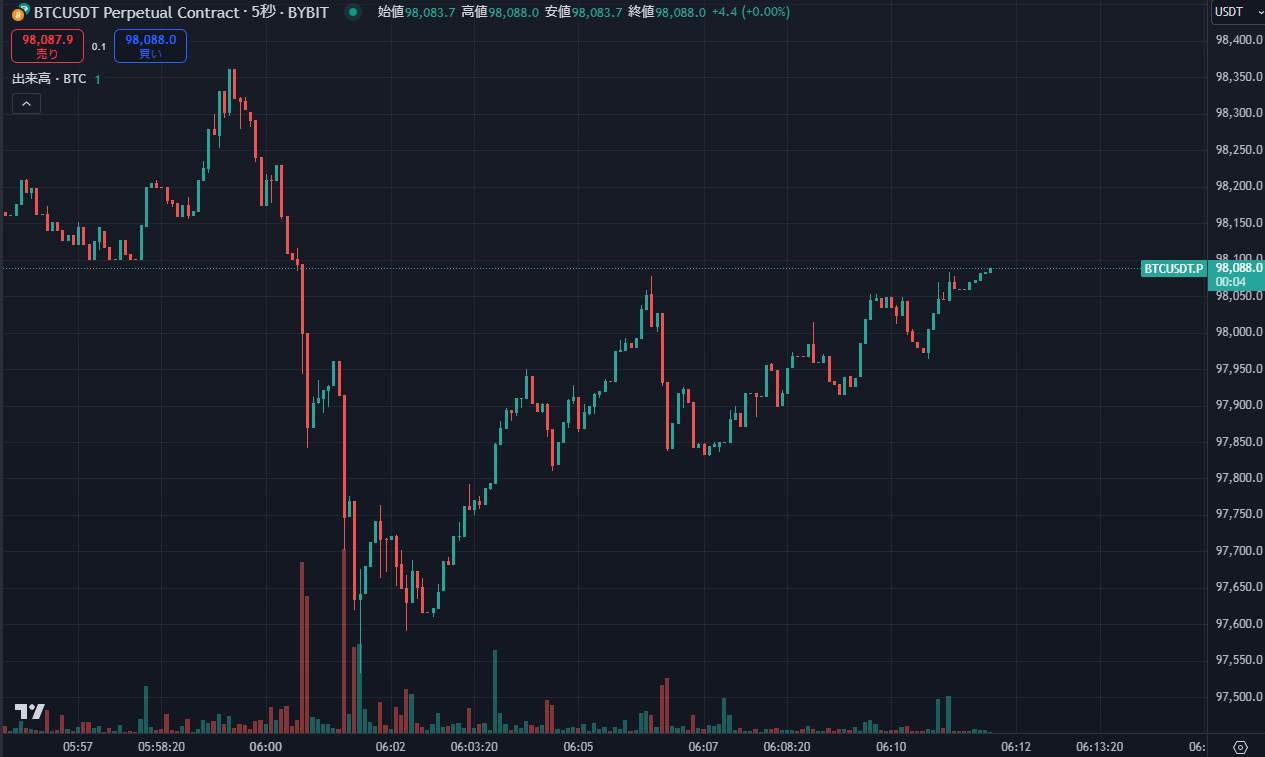

In [7]:
Image('./images/15_01.png', width=800)

## 約定履歴とは

- 1回1回の買いと売りのマッチング（約定）をすべてデータとして記録したもの。
- 約定時刻、約定価格、約定枚数、テイカーサイド（買い側が成行か、売り側が成行か）などのデータ。
- 1日分だけで数千万行になることもある。そのままだと取得や保存に結構コストがかかる。

# データ取得

- 今回はbybitの約定履歴を利用します。なぜか？

- 通常、約定履歴は件数が多く、全件取得にAPIコールをたくさん使う必要があります（一度に1000件までしか取得できない、みたいな制約がある）。
- bybitは、海外の主要取引所の1つで、BTCUSDTの無期限先物があり、参加者が多く出来高がかなり大きいです。
- かつ、約定履歴を日毎にCSVデータで一括取得できます。
- https://www.bybit.com/derivatives/ja-JP/history-data

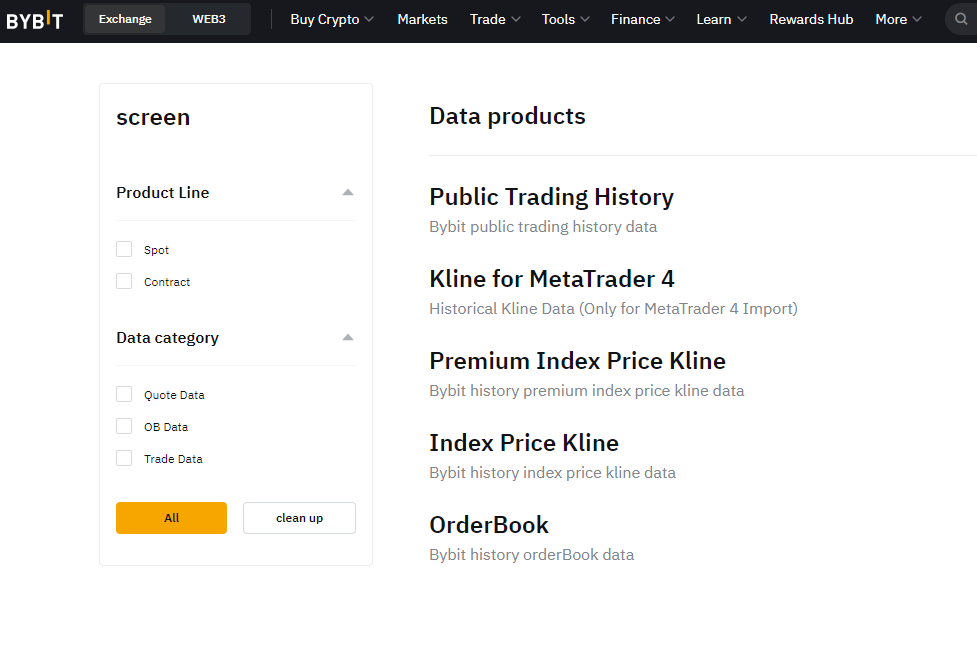

In [8]:
Image('./images/15_02.png', width=800)

- ここからデータをダウンロードして解凍して、読み込んでみます。

In [9]:
executions = pd.read_csv('./data/15_BTCUSDT2024-11-20.csv')

- 11月20日（日本時間朝9:00～翌9:00までの24時間）のデータ。
- 217万件のデータが保持されている。

In [10]:
executions

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
0,1.732061e+09,BTCUSDT,Sell,0.001,92341.6,PlusTick,9118b134-df56-5112-b809-c68b15600def,9.234160e+09,0.001,92.3416
1,1.732061e+09,BTCUSDT,Sell,0.036,92341.6,ZeroPlusTick,7fca6449-ba46-5527-8c42-c542927902c8,3.324298e+11,0.036,3324.2976
2,1.732061e+09,BTCUSDT,Buy,0.006,92341.7,PlusTick,3bfbaf05-0da3-5c4e-8fbe-a6cafc650e17,5.540502e+10,0.006,554.0502
3,1.732061e+09,BTCUSDT,Buy,0.059,92341.7,ZeroPlusTick,57cc1094-55e3-5d3d-b8d3-54bc9bd0842f,5.448160e+11,0.059,5448.1603
4,1.732061e+09,BTCUSDT,Sell,0.495,92341.6,MinusTick,009296af-e52a-5789-948c-545162d93466,4.570909e+12,0.495,45709.0920
...,...,...,...,...,...,...,...,...,...,...
2177724,1.732147e+09,BTCUSDT,Buy,0.258,94315.1,ZeroPlusTick,5c745508-7881-5091-9231-fbaffa8e446d,2.433330e+12,0.258,24333.2958
2177725,1.732147e+09,BTCUSDT,Buy,0.523,94315.3,PlusTick,4597b164-d896-5f73-8da5-c5e4e32a4fea,4.932690e+12,0.523,49326.9019
2177726,1.732147e+09,BTCUSDT,Buy,0.072,94315.3,ZeroPlusTick,8d4a39d4-526b-5a31-b6ac-39f804e34417,6.790702e+11,0.072,6790.7016
2177727,1.732147e+09,BTCUSDT,Buy,0.031,94315.3,ZeroPlusTick,5834496f-7996-59cb-b619-f9445bd8f472,2.923774e+11,0.031,2923.7743


- このデータを整形して、秒足を作成していきます。

# 秒足作成

- いつものようにresampleメソッドを使うため、DataFrameのindexをdatetime型に変更します。

In [11]:
executions.index = pd.to_datetime(executions['timestamp'], unit='s', utc=True)
executions

,timestamp,symbol,side,size,price,tickDirection,trdMatchID,grossValue,homeNotional,foreignNotional
timestamp,,,,,,,,,,
2024-11-20 00:00:00.061899900+00:00,1.732061e+09,BTCUSDT,Sell,0.001,92341.6,PlusTick,9118b134-df56-5112-b809-c68b15600def,9.234160e+09,0.001,92.3416
2024-11-20 00:00:00.061899900+00:00,1.732061e+09,BTCUSDT,Sell,0.036,92341.6,ZeroPlusTick,7fca6449-ba46-5527-8c42-c542927902c8,3.324298e+11,0.036,3324.2976
2024-11-20 00:00:00.064699888+00:00,1.732061e+09,BTCUSDT,Buy,0.006,92341.7,PlusTick,3bfbaf05-0da3-5c4e-8fbe-a6cafc650e17,5.540502e+10,0.006,554.0502
2024-11-20 00:00:00.064699888+00:00,1.732061e+09,BTCUSDT,Buy,0.059,92341.7,ZeroPlusTick,57cc1094-55e3-5d3d-b8d3-54bc9bd0842f,5.448160e+11,0.059,5448.1603
2024-11-20 00:00:00.069499969+00:00,1.732061e+09,BTCUSDT,Sell,0.495,92341.6,MinusTick,009296af-e52a-5789-948c-545162d93466,4.570909e+12,0.495,45709.0920
...,...,...,...,...,...,...,...,...,...,...
2024-11-20 23:59:59.344199896+00:00,1.732147e+09,BTCUSDT,Buy,0.258,94315.1,ZeroPlusTick,5c745508-7881-5091-9231-fbaffa8e446d,2.433330e+12,0.258,24333.2958
2024-11-20 23:59:59.344199896+00:00,1.732147e+09,BTCUSDT,Buy,0.523,94315.3,PlusTick,4597b164-d896-5f73-8da5-c5e4e32a4fea,4.932690e+12,0.523,49326.9019
2024-11-20 23:59:59.344599962+00:00,1.732147e+09,BTCUSDT,Buy,0.072,94315.3,ZeroPlusTick,8d4a39d4-526b-5a31-b6ac-39f804e34417,6.790702e+11,0.072,6790.7016


- resampleメソッドでOHLCVを作成します。

In [12]:
term = '5s'
offset = '0'
ohlcv = pd.concat([
    # Open
    executions['price'].resample(term, offset=offset).first(),
    # High
    executions['price'].resample(term, offset=offset).max(),
    # Low
    executions['price'].resample(term, offset=offset).min(),
    # Close
    executions['price'].resample(term, offset=offset).last(),
    # Volume
    executions['size'].resample(term, offset=offset).sum(),
    # Quote Volume (bybitの場合はforeignNotionalカラムの集計でもOK)
    (executions['size'] * executions['price']).resample(term, offset=offset).sum(),
], axis=1)

# カラム名を変更
ohlcv.columns = ['open', 'high', 'low', 'close', 'volume', 'quote_volume']

In [13]:
ohlcv

,open,high,low,close,volume,quote_volume
timestamp,,,,,,
2024-11-20 00:00:00+00:00,92341.6,92342.4,92334.1,92334.2,16.067,1.483634e+06
2024-11-20 00:00:05+00:00,92334.2,92334.2,92326.2,92326.3,7.468,6.895152e+05
2024-11-20 00:00:10+00:00,92326.2,92326.2,92317.0,92317.0,8.909,8.225157e+05
2024-11-20 00:00:15+00:00,92317.0,92340.2,92312.7,92340.2,11.003,1.015744e+06
2024-11-20 00:00:20+00:00,92340.2,92340.3,92332.4,92332.4,3.161,2.918832e+05
...,...,...,...,...,...,...
2024-11-20 23:59:35+00:00,94315.3,94315.3,94313.5,94313.6,0.789,7.441385e+04
2024-11-20 23:59:40+00:00,94313.6,94313.6,94313.5,94313.6,2.570,2.423857e+05
2024-11-20 23:59:45+00:00,94313.5,94313.6,94313.5,94313.6,1.627,1.534482e+05


- プロット（5秒足1日分だと結構重い）

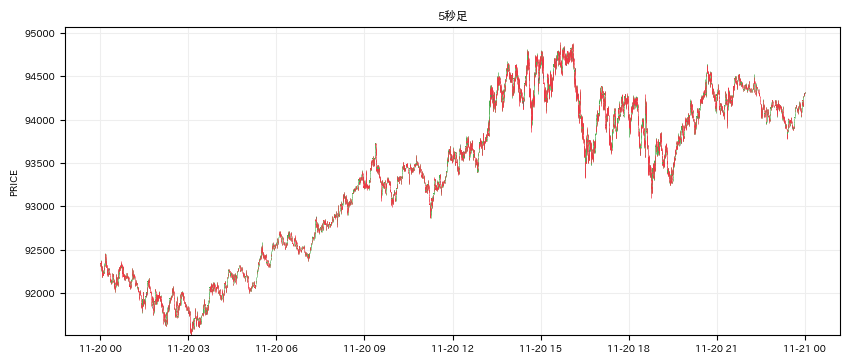

In [64]:
plt.figure(figsize=(10, 4))
plot_ohlc(ohlcv, sec=5, title='5秒足');

- プロット（最初の30分）

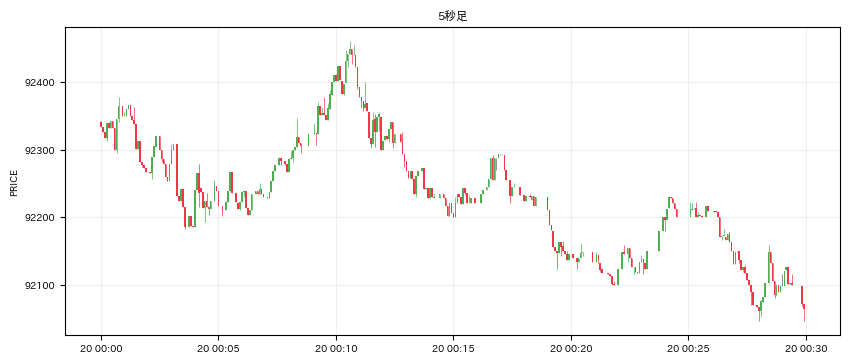

In [14]:
plt.figure(figsize=(10, 4))
plot_ohlc(ohlcv[:12*30], sec=5, title='5秒足');

## Buy VolumeとSell Volumeの追加

- せっかくなので、Buy VolumeとSell Volumeを集計しておきます。
- マイクロストラクチャーの分析に役立ちます。
- 取引所によっては、清算時の約定履歴を取得したり、該当の約定が清算時の約定かを判定できるものがあります。こういうものを使うと分析の幅が広がります。

In [15]:
buy_executions = executions[executions['side'] == 'Buy']
sell_executions = executions[executions['side'] == 'Sell']
ohlcv['buy_volume'] = buy_executions['size'].resample(term, offset=offset).sum()
ohlcv['buy_quote_volume'] = (buy_executions['size'] * buy_executions['price']).resample(term, offset=offset).sum()
ohlcv['sell_volume'] = sell_executions['size'].resample(term, offset=offset).sum()
ohlcv['sell_quote_volume'] = (sell_executions['size'] * sell_executions['price']).resample(term, offset=offset).sum()

In [16]:
ohlcv

,open,high,low,close,volume,quote_volume,buy_volume,buy_quote_volume,sell_volume,sell_quote_volume
timestamp,,,,,,,,,,
2024-11-20 00:00:00+00:00,92341.6,92342.4,92334.1,92334.2,16.067,1.483634e+06,5.128,473512.1944,10.939,1.010122e+06
2024-11-20 00:00:05+00:00,92334.2,92334.2,92326.2,92326.3,7.468,6.895152e+05,3.069,283351.7074,4.399,4.061635e+05
2024-11-20 00:00:10+00:00,92326.2,92326.2,92317.0,92317.0,8.909,8.225157e+05,0.023,2123.3023,8.886,8.203924e+05
2024-11-20 00:00:15+00:00,92317.0,92340.2,92312.7,92340.2,11.003,1.015744e+06,8.718,804787.6485,2.285,2.109559e+05
2024-11-20 00:00:20+00:00,92340.2,92340.3,92332.4,92332.4,3.161,2.918832e+05,0.886,81809.3267,2.275,2.100739e+05
...,...,...,...,...,...,...,...,...,...,...
2024-11-20 23:59:35+00:00,94315.3,94315.3,94313.5,94313.6,0.789,7.441385e+04,0.165,15561.8273,0.624,5.885202e+04
2024-11-20 23:59:40+00:00,94313.6,94313.6,94313.5,94313.6,2.570,2.423857e+05,0.044,4149.7984,2.526,2.382359e+05
2024-11-20 23:59:45+00:00,94313.5,94313.6,94313.5,94313.6,1.627,1.534482e+05,1.485,140055.6960,0.142,1.339252e+04


# 秒足の分析

- ここからは簡単な分析を行っていきます。

## 秒足リターンを計算

In [17]:
ohlcv['ror'] = (ohlcv['close'] - ohlcv['open']) / ohlcv['open']

## リターンの自己相関（ラグ1, 2, 3）

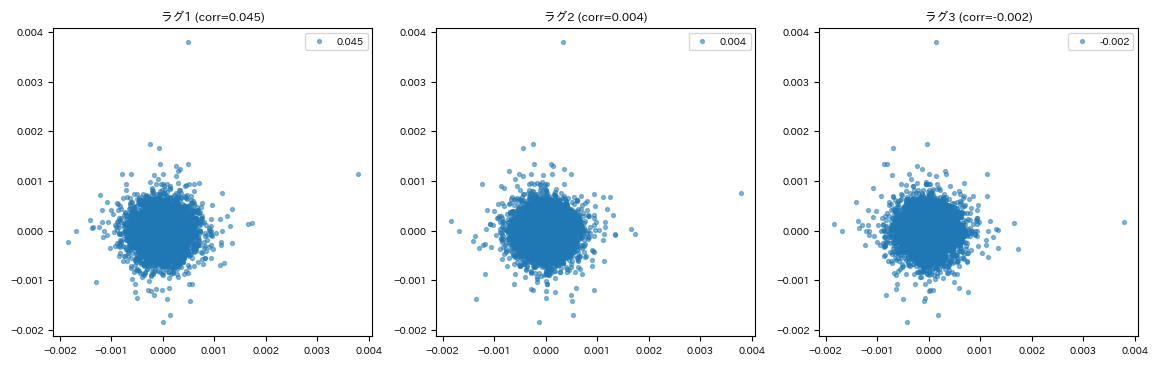

In [18]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plot_corr(ohlcv['ror'].shift(1), ohlcv['ror'], title='ラグ1')
plt.subplot(1, 3, 2)
plot_corr(ohlcv['ror'].shift(2), ohlcv['ror'], title='ラグ2')
plt.subplot(1, 3, 3)
plot_corr(ohlcv['ror'].shift(3), ohlcv['ror'], title='ラグ3');

- ラグ1に若干の順相関が見られます。

## Volume差分とリターンの関係（ラグ0, 1, 2）

- Volume差分は、買いVolume - 売りVolume です。価格に影響を与えます。

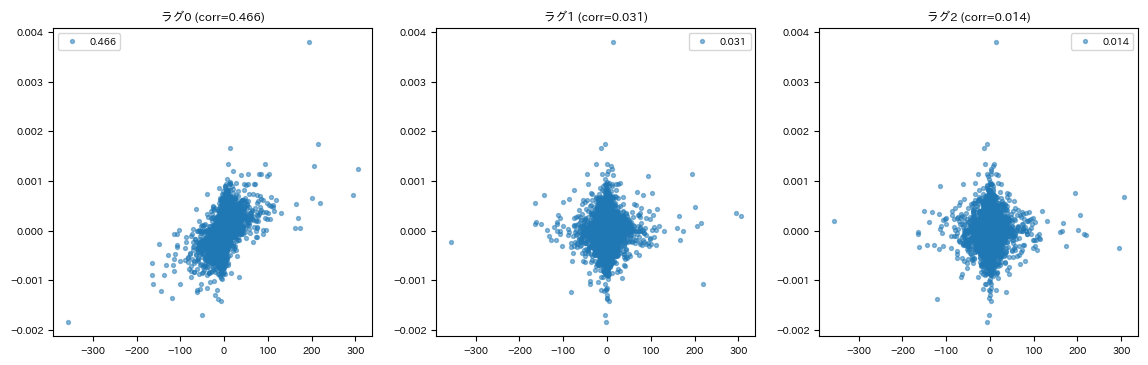

In [19]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plot_corr((ohlcv['buy_volume'] - ohlcv['sell_volume']), ohlcv['ror'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr((ohlcv['buy_volume'] - ohlcv['sell_volume']).shift(1), ohlcv['ror'], title='ラグ1')
plt.subplot(1, 3, 3)
plot_corr((ohlcv['buy_volume'] - ohlcv['sell_volume']).shift(2), ohlcv['ror'], title='ラグ2');

- ラグ0では強い順相関が見られます。買いが多いとその足の価格が上昇する、逆もまた然りということです。
- ラグ1でも影響がほんの少し残っていますが、強くはありません。
- ラグ2ではさらに影響が小さくなります。

## 秒グループごとの平均値幅、平均リターンの計算

- 各足の秒数（5, 10, 15,...）でGroupByできるようにします。

In [20]:
tmp = ohlcv.copy()
tmp['abs_ror'] = np.abs(tmp['ror'])
tmp['sec'] = tmp.index.second

In [21]:
tmp

,open,high,low,close,volume,quote_volume,buy_volume,buy_quote_volume,sell_volume,sell_quote_volume,ror,abs_ror,sec
timestamp,,,,,,,,,,,,,
2024-11-20 00:00:00+00:00,92341.6,92342.4,92334.1,92334.2,16.067,1.483634e+06,5.128,473512.1944,10.939,1.010122e+06,-0.000080,0.000080,0
2024-11-20 00:00:05+00:00,92334.2,92334.2,92326.2,92326.3,7.468,6.895152e+05,3.069,283351.7074,4.399,4.061635e+05,-0.000086,0.000086,5
2024-11-20 00:00:10+00:00,92326.2,92326.2,92317.0,92317.0,8.909,8.225157e+05,0.023,2123.3023,8.886,8.203924e+05,-0.000100,0.000100,10
2024-11-20 00:00:15+00:00,92317.0,92340.2,92312.7,92340.2,11.003,1.015744e+06,8.718,804787.6485,2.285,2.109559e+05,0.000251,0.000251,15
2024-11-20 00:00:20+00:00,92340.2,92340.3,92332.4,92332.4,3.161,2.918832e+05,0.886,81809.3267,2.275,2.100739e+05,-0.000084,0.000084,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-20 23:59:35+00:00,94315.3,94315.3,94313.5,94313.6,0.789,7.441385e+04,0.165,15561.8273,0.624,5.885202e+04,-0.000018,0.000018,35
2024-11-20 23:59:40+00:00,94313.6,94313.6,94313.5,94313.6,2.570,2.423857e+05,0.044,4149.7984,2.526,2.382359e+05,0.000000,0.000000,40
2024-11-20 23:59:45+00:00,94313.5,94313.6,94313.5,94313.6,1.627,1.534482e+05,1.485,140055.6960,0.142,1.339252e+04,0.000001,0.000001,45


- まず、リターンの絶対値の平均を取ることで、「平均値幅（平均ボラティリティ）」をプロットします。

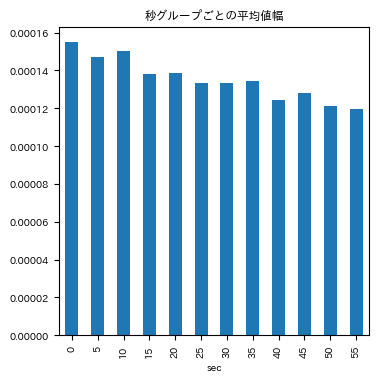

In [22]:
tmp.groupby('sec')['abs_ror'].mean().plot(kind='bar', title='秒グループごとの平均値幅');

- きれいに右肩下がりになっています。
- これはつまり、0～5秒での価格変動が最も大きく、秒数が経過するごとに変動が小さくなる傾向を表しています。

- 続いて、絶対値を取らない「平均リターン」をプロットします。

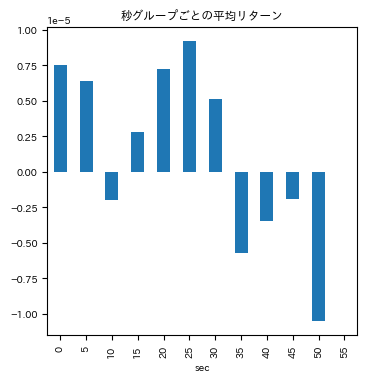

In [23]:
tmp.groupby('sec')['ror'].mean().plot(kind='bar', title='秒グループごとの平均リターン');

- <font color="red">0秒～30秒にかけてはプラスの傾向、30秒以後～59秒にかけてはマイナスの傾向がはっきり出ています。</font>
- 執行の際、買いなら00秒より前、売りなら30秒あたりで売ることで有利に執行できる可能性があります。

- これは以前、UKIがnoteで紹介していた00秒-30秒アノマリーです。
- https://note.com/uki_profit/n/n84ae4a6665b2

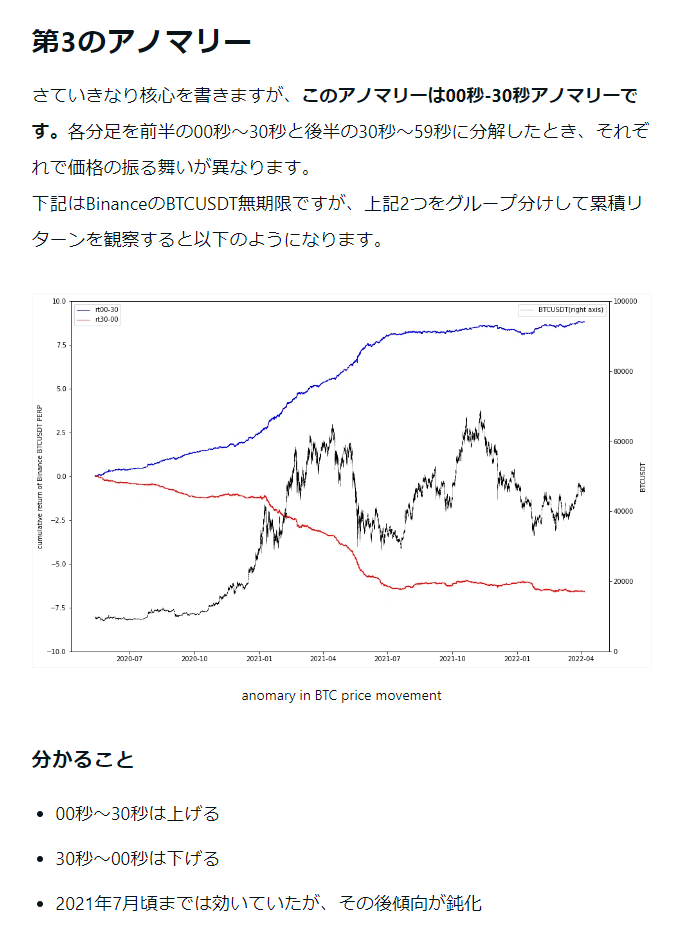

In [24]:
Image('./images/15_03.png')

- 記事中では「鈍化して効かなくなった」とありますが、現在の活況相場では十分効いている可能性があります（上げ相場だから効いてるだけ、の可能性もある）

## 取引所間での価格伝播 ビットバンクの例

- ビットバンクのBTCJPYの約定履歴を取得します。
- ビットバンクは1日ごとに約定履歴を取得可能なので楽です。

In [25]:
bitbank_executions = requests.get('https://public.bitbank.cc/btc_jpy/transactions/20241120').json()['data']['transactions']
bitbank_executions = pd.DataFrame(bitbank_executions)

In [26]:
bitbank_executions

,transaction_id,side,price,amount,executed_at
0,1179259833,buy,14328621,0.0001,1732060804099
1,1179259841,buy,14328621,0.0001,1732060810769
2,1179259851,buy,14328621,0.0001,1732060815892
3,1179259854,buy,14328621,0.0001,1732060827021
4,1179259866,buy,14328621,0.0009,1732060842760
...,...,...,...,...,...
16474,1179405716,sell,14669999,0.0036,1732147115315
16475,1179405718,buy,14670000,0.0010,1732147121698
16476,1179405743,buy,14670000,0.0052,1732147160497
16477,1179405745,buy,14670000,0.0016,1732147164432


- resampleのためにindexを変更します。

In [27]:
bitbank_executions.index = pd.to_datetime(bitbank_executions['executed_at'] / 1000, unit='s', utc=True)
bitbank_executions

,transaction_id,side,price,amount,executed_at
executed_at,,,,,
2024-11-20 00:00:04.098999977+00:00,1179259833,buy,14328621,0.0001,1732060804099
2024-11-20 00:00:10.769000053+00:00,1179259841,buy,14328621,0.0001,1732060810769
2024-11-20 00:00:15.891999960+00:00,1179259851,buy,14328621,0.0001,1732060815892
2024-11-20 00:00:27.020999908+00:00,1179259854,buy,14328621,0.0001,1732060827021
2024-11-20 00:00:42.759999990+00:00,1179259866,buy,14328621,0.0009,1732060842760
...,...,...,...,...,...
2024-11-20 23:58:35.315000057+00:00,1179405716,sell,14669999,0.0036,1732147115315
2024-11-20 23:58:41.697999954+00:00,1179405718,buy,14670000,0.0010,1732147121698
2024-11-20 23:59:20.496999979+00:00,1179405743,buy,14670000,0.0052,1732147160497


- priceとamount カラムがobject型に変換されたため、floatに変更します。

In [28]:
bitbank_executions['price'] = bitbank_executions['price'].astype(float)
bitbank_executions['amount'] = bitbank_executions['amount'].astype(float)

- 5秒足を作成します。

In [29]:
term = '5s'
offset = 0
bitbank_ohlcv = pd.concat([
    # Open
    bitbank_executions['price'].resample(term, offset=offset).first(),
    # High
    bitbank_executions['price'].resample(term, offset=offset).max(),
    # Low
    bitbank_executions['price'].resample(term, offset=offset).min(),
    # Close
    bitbank_executions['price'].resample(term, offset=offset).last(),
    # Volume
    bitbank_executions['amount'].resample(term, offset=offset).sum(),
    # Quote Volume (bybitの場合はforeignNotionalカラムの集計でもOK)
    (bitbank_executions['amount'] * bitbank_executions['price']).resample(term, offset=offset).sum(),
], axis=1)

# カラム名を変更
bitbank_ohlcv.columns = ['open', 'high', 'low', 'close', 'volume', 'quote_volume']

In [30]:
bitbank_ohlcv

,open,high,low,close,volume,quote_volume
executed_at,,,,,,
2024-11-20 00:00:00+00:00,14328621.0,14328621.0,14328621.0,14328621.0,0.0001,1432.8621
2024-11-20 00:00:05+00:00,NaN,NaN,NaN,NaN,0.0000,0.0000
2024-11-20 00:00:10+00:00,14328621.0,14328621.0,14328621.0,14328621.0,0.0001,1432.8621
2024-11-20 00:00:15+00:00,14328621.0,14328621.0,14328621.0,14328621.0,0.0001,1432.8621
2024-11-20 00:00:20+00:00,NaN,NaN,NaN,NaN,0.0000,0.0000
...,...,...,...,...,...,...
2024-11-20 23:59:25+00:00,NaN,NaN,NaN,NaN,0.0000,0.0000
2024-11-20 23:59:30+00:00,NaN,NaN,NaN,NaN,0.0000,0.0000
2024-11-20 23:59:35+00:00,NaN,NaN,NaN,NaN,0.0000,0.0000


- 欠損を埋めます。4本値の欠損を埋める場合、
  - まずcloseを、前方fillで埋めます。
  - 残りをcloseに合わせます。

In [31]:
bitbank_ohlcv['close'] = bitbank_ohlcv['close'].fillna(method='ffill')
bitbank_ohlcv['open'] = bitbank_ohlcv['open'].fillna(bitbank_ohlcv['close'])
bitbank_ohlcv['high'] = bitbank_ohlcv['high'].fillna(bitbank_ohlcv['close'])
bitbank_ohlcv['low'] = bitbank_ohlcv['low'].fillna(bitbank_ohlcv['close'])

In [32]:
bitbank_ohlcv

,open,high,low,close,volume,quote_volume
executed_at,,,,,,
2024-11-20 00:00:00+00:00,14328621.0,14328621.0,14328621.0,14328621.0,0.0001,1432.8621
2024-11-20 00:00:05+00:00,14328621.0,14328621.0,14328621.0,14328621.0,0.0000,0.0000
2024-11-20 00:00:10+00:00,14328621.0,14328621.0,14328621.0,14328621.0,0.0001,1432.8621
2024-11-20 00:00:15+00:00,14328621.0,14328621.0,14328621.0,14328621.0,0.0001,1432.8621
2024-11-20 00:00:20+00:00,14328621.0,14328621.0,14328621.0,14328621.0,0.0000,0.0000
...,...,...,...,...,...,...
2024-11-20 23:59:25+00:00,14670000.0,14670000.0,14670000.0,14670000.0,0.0000,0.0000
2024-11-20 23:59:30+00:00,14670000.0,14670000.0,14670000.0,14670000.0,0.0000,0.0000
2024-11-20 23:59:35+00:00,14670000.0,14670000.0,14670000.0,14670000.0,0.0000,0.0000


- プロットします。
- ビットバンク現物の出来高は海外取引所のデリバティブと比べてかなり少ないため、短い足ではこのようなチャートになります。

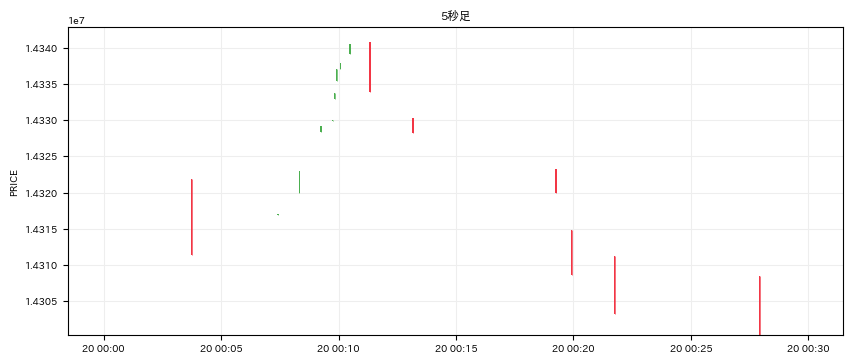

In [33]:
plt.figure(figsize=(10, 4))
plot_ohlc(bitbank_ohlcv[:12*30], sec=5, title='5秒足');

- リターンを計算しておきます。

In [34]:
bitbank_ohlcv['ror'] = (bitbank_ohlcv['close'] - bitbank_ohlcv['open']) / bitbank_ohlcv['open']

### bybit → bitbankの価格伝播の様子

In [35]:
tmp = ohlcv.copy()
tmp['bitbank_ror'] = bitbank_ohlcv['ror']

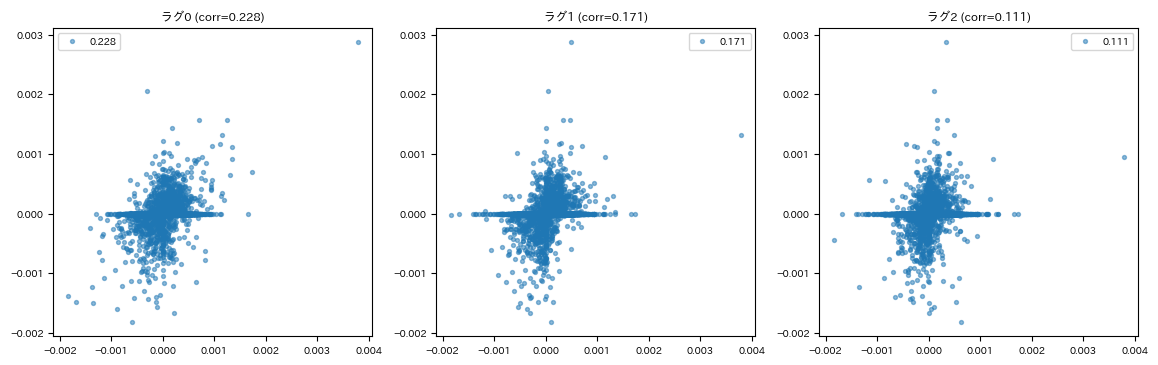

In [36]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plot_corr(tmp['ror'], tmp['bitbank_ror'], title='ラグ0')
plt.subplot(1, 3, 2)
plot_corr(tmp['ror'].shift(1), tmp['bitbank_ror'], title='ラグ1')
plt.subplot(1, 3, 3)
plot_corr(tmp['ror'].shift(2), tmp['bitbank_ror'], title='ラグ2');

- ラグ1やラグ2でも強い影響が残っていることが分かります。
- これにより、ごく短期での価格の方向予測を行うことができます。
- <font color="red">ただし、コストの観点から簡単に収益化することはできません。</font>

## 知見

- 基本的に、出来高の少ない取引所の価格は、出来高の多い取引所の価格に追随します。
- ただし、コストの観点から簡単に収益化することはできません。
- アイデア
  - この指標を直接使うのではなく、他の指標や戦略とあわせて使う。
  - 指標をもっと強くする。
  - 指標の動きをさらに予測する。

# まとめ

- 約定履歴や板の分析の基礎として、約定履歴を使った5秒足の作成方法を解説した。
- 5秒足を分析することで、1分未満の時間軸での価格変動の傾向を明らかにした。
- また、ごく短期での価格変動の方向予測の可能性を示した。
- これらは高頻度取引や有利な執行に役立てることができる。